In [2]:
# Packages
import numpy as np
import sklearn 
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from scipy.integrate import odeint
import math
import os

from utility_code.utility import utils

dir_path = os.getcwd()

#import csvs
train_round2 = pd.read_csv("train_round2_updated/train_round2_updated.csv")

train_round2['Population'] = train_round2['Confirmed'].divide(train_round2['Incident_Rate'])*1e5
train_round2['Active/Population'] = train_round2['Active'].divide(train_round2['Population'])
train_round2['Deaths/Population'] = train_round2['Deaths'].divide(train_round2['Population'])
train_round2['Active/People_Tested*Population'] = train_round2['Active']/train_round2['People_Tested']*train_round2['Population']
train_round2['Recovered/Population'] = train_round2['Recovered']/train_round2['Population']


confirmed = train_round2['Confirmed'].to_list()
daily = [confirmed[i]-confirmed[i-50] for i in range(len(confirmed)) if i-50 >= 0]
for i in range(50):
    daily.insert(0,0)

train_round2['New_Cases'] = daily

tests = train_round2['People_Tested'].to_list()
dailyTests = [tests[i]-tests[i-50] for i in range(len(tests)) if i-50 >= 0]
for i in range(50):
    dailyTests.insert(0,0)

train_round2['New_Tests'] = dailyTests

train_round2['New_Cases/New_Tests'] = train_round2['New_Cases']/train_round2['New_Tests']

statesdata = {}
states = pd.Series.unique(train_round2['Province_State'])
num_states = len(states)
for s in states:
    statesdata[s] = train_round2.loc[train_round2['Province_State'] == s ,:]

statesdata['California']

,ID,Province_State,Date,Confirmed,Deaths,Recovered,Active,Incident_Rate,People_Tested,People_Hospitalized,...,UID,ISO3,Population,Active/Population,Deaths/Population,Active/People_Tested*Population,Recovered/Population,New_Cases,New_Tests,New_Cases/New_Tests
4,4,California,04-12-2020,22795,640,NaN,22155.0,58.137726,190328.0,5234.0,...,NaN,NaN,3.920862e+07,0.000565,0.000016,4.564052e+06,NaN,0,0.0,NaN
54,54,California,04-13-2020,23931,714,NaN,23217.0,61.035048,190882.0,3015.0,...,NaN,NaN,3.920862e+07,0.000592,0.000018,4.768949e+06,NaN,1136,554.0,2.050542
104,104,California,04-14-2020,25356,767,NaN,24589.0,64.669453,202208.0,5163.0,...,NaN,NaN,3.920862e+07,0.000627,0.000020,4.767867e+06,NaN,1425,11326.0,0.125817
154,154,California,04-15-2020,26686,860,NaN,25826.0,68.061564,216486.0,5163.0,...,NaN,NaN,3.920862e+07,0.000659,0.000022,4.677447e+06,NaN,1330,14278.0,0.093150
204,204,California,04-16-2020,27677,956,NaN,26721.0,70.589069,246400.0,5031.0,...,NaN,NaN,3.920862e+07,0.000682,0.000024,4.252003e+06,NaN,991,29914.0,0.033128
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11654,11654,California,12-01-2020,1246042,19304,NaN,1226738.0,3153.560861,NaN,NaN,...,84000006.0,USA,3.951222e+07,0.031047,0.000489,NaN,NaN,15778,NaN,NaN
11704,11704,California,12-02-2020,1265182,19410,NaN,1245772.0,3202.001568,NaN,NaN,...,84000006.0,USA,3.951222e+07,0.031529,0.000491,NaN,NaN,19140,NaN,NaN
11754,11754,California,12-03-2020,1286550,19553,NaN,1266997.0,3256.081036,NaN,NaN,...,84000006.0,USA,3.951222e+07,0.032066,0.000495,NaN,NaN,21368,NaN,NaN
11804,11804,California,12-04-2020,1310307,19734,NaN,1290573.0,3316.206734,NaN,NaN,...,84000006.0,USA,3.951222e+07,0.032663,0.000499,NaN,NaN,23757,NaN,NaN


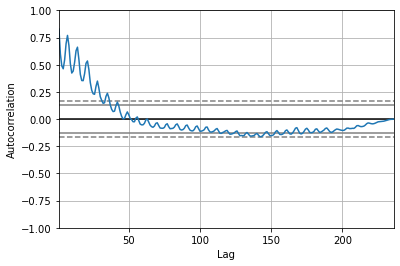

In [3]:
import pandas as pd
confirmed = statesdata['Wisconsin']['Confirmed']
deaths = statesdata['Wisconsin']['Deaths']
deaths = deaths.values
confirmed = confirmed.values
def difference(dataset, interval = 1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i]-dataset[i-interval]
        diff.append(value)
    return np.array(diff)

deaths = difference(deaths,2)

pd.plotting.autocorrelation_plot(deaths)

In [ ]:
import pmdarima as pm

statesPlots = []
for s in statesdata:
    X = statesdata[s]['Confirmed']
    splitpt = len(X) - 20
    X = X.values
    X_train, X_test = X[0:splitpt], X[splitpt:]
    arima = pm.auto_arima(X_train, error_action='ignore', trace=True,
                          suppress_warnings=True, maxiter=25,
                          seasonal= False, out_of_sample_size=10)

    x = np.arange(X_test.shape[0])
    plt.scatter(x, X_test, marker='x')
    print(arima.predict(n_periods = X_test.shape[0]))
    plt.title('Actual test samples vs. forecasts')
    plt.plot(x, arima.predict(n_periods=X_test.shape[0]))
#     statesPlots.append(plt)
    
# for s in statesPlots:
#     s.show()

In [8]:
import warnings
warnings.filterwarnings('ignore')
p,d,q = 5,2,1
days = 26
mapeTotC = 0
mapeTotD = 0

from statsmodels.tsa.arima_model import ARIMA
#from statsmodels.tsa.arima_model import SARIMAX

def predictARIMA(X, p, d, q, days):
    model = ARIMA(X, order=(p,d,q))
    try:
        model_fit = model.fit()
    except:
        return (-1,0)
    start = len(X)
    forecast = model_fit.predict(start = start, end = start + days -1)
    return(forecast)

def difference(dataset, interval = 1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i]-dataset[i-interval]
        diff.append(value)
    return np.array(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
    #yhat = np.exp(yhat)
    return yhat + history[-1]

from statsmodels.tsa.arima.model import ARIMA
days = 15
proj = {}
for p in [1,3,5,7]:
    for d in [1,2,3]:
        for q in [1,3,5]:
            if q  > p: continue
            for s in states:

                a = statesdata[s]
                a = a.reset_index()
                confirmed = a['Confirmed']
                deaths = a['Deaths']

                splitpt = len(confirmed) - days
                confirmed_train, confirmed_test = confirmed[0:splitpt], confirmed[splitpt:]
                deaths_train, deaths_test = deaths[0:splitpt], deaths[splitpt:]

                X = confirmed_train.values
                #X = X+0.000001 # pseudocount to avoid log(0)
                #X = np.log(X)
            #     arimaC = pm.auto_arima(confirmed_train, error_action='ignore', trace=True, start_p=5, 
            #                            max_p = 10, start_d = 1, max_d=3, start_q=1, max_q=4,
            #                       suppress_warnings=True, maxiter=25,
            #                       seasonal= True, m=3)
            #     forecastC = arimaC.predict(n_periods = 15)
                forecastC = predictARIMA(X, p,d,q, days)
            #     modelC = ARIMA(X, order=(5,2,3))
            #     model_fitC = modelC.fit()
            #     start = len(X)
            #     forecastC = model_fitC.predict(start = start, end = start + days)

                Y= deaths_train.values
                #Y = Y+0.000001
                #Y = np.log(Y)
            #     arimaD = pm.auto_arima(deaths_train, error_action='ignore', trace=True,start_p=5, 
            #                            max_p = 10, start_d = 1, max_d=3, start_q=1, max_q=4,
            #                       suppress_warnings=True, maxiter=25,
            #                       seasonal= True, m=3)
                #forecastD = arimaD.predict(n_periods = 15)
                forecastD = predictARIMA(Y, p,d,q, days)
                if forecastD[0] == -1:
                    print('That sucks')
                    continue
            #     modelD = ARIMA(Y, order=(5,2,3))
            #     model_fitD = modelD.fit()
            #     start = len(Y)
            #     forecastD = model_fitD.predict(start = start, end = start + days)
                #forecastC = np.exp(forecastC)
                #forecastD = np.exp(forecastD)
                df = {'Confirmed': forecastC, 'Deaths': forecastD}

                proj[s] = pd.DataFrame(df)
                mapeC = MAPE(forecastC, confirmed_test)
                mapeD = MAPE(forecastD, deaths_test)
                mapeTotC += mapeC
                mapeTotD += mapeD
                #print('For', s, '\n Confirmed MAPE:',mapeC, '\n Deaths MAPE:', mapeD)

            print('Params:', p,d,q, 'MAPE C', mapeTotC, 'MAPE D', mapeTotD)
            mapeTotC = 0
            mapeTotD = 0

Params: 1 1 1 MAPE C 1.3072092334897807 MAPE D 1.2635694061366185
Params: 1 2 1 MAPE C 1.104350579057621 MAPE D 0.9928251200024724
Params: 1 3 1 MAPE C 1.5701945356683942 MAPE D 1.6941868153749253
Params: 3 1 1 MAPE C 1.2299518860248813 MAPE D 1.0836123973154725
That sucks
Params: 3 1 3 MAPE C 1.1245752818168824 MAPE D 0.9972579662990274
Params: 3 2 1 MAPE C 1.0498287956669579 MAPE D 0.9807949859072426
Params: 3 2 3 MAPE C 1.0383963930915647 MAPE D 0.9748091684715336
Params: 3 3 1 MAPE C 1.505153484587652 MAPE D 1.4347946025044538
Params: 3 3 3 MAPE C 1.544187027288131 MAPE D 1.3471182023397141
Params: 5 1 1 MAPE C 1.1888626426187363 MAPE D 1.1411762383132968
That sucks
Params: 5 1 3 MAPE C 1.186081740427886 MAPE D 1.0690294560086844
Params: 5 1 5 MAPE C 1.1571779749088342 MAPE D 0.9606354063805911
Params: 5 2 1 MAPE C 1.0413362807573283 MAPE D 0.9386545328130206
Params: 5 2 3 MAPE C 0.9705766972557559 MAPE D 0.918544208722385
That sucks
That sucks
Params: 5 2 5 MAPE C 1.10966182689944

In [6]:
def MAPE(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true))
#
#MAPE(submission[['Confirmed', 'Deaths']], validation[['Confirmed', 'Deaths']])

Without the trend parameter for confirmed: 0.22241363123139815
Without the trend parameter for deaths: 0.26647074317976094
    
With the params, 4,2,3 for confirmed: 0.21210243608979962
With the 4,2,3 for deaths: 0.26341990030777807
    
With the params, 2,2,3 for confirmed: 0.1893949194911668
With the 2,2,3 for deaths: 0.25949362504775464
    
With the 6,2,3 for deaths: 0.24447115807485809
    
With the params, 4,2,1 for confirmed: 0.20066623728045355
With the 4,2,1 for deaths: 0.23821759832698347
    
With the params 4,2,0 for confirmed: 0.14797518105639543
With the parms above for deaths: 0.2358201596243279
    
With the params 1,1,1 for confirmed: 0.17404089441983467
With the parms above for deaths: 0.26697120703684923
    
With the params 2,2,2 for confirmed: 0.18581905974534663
With the parms above for deaths: 0.2611015188110797

With the params 4,2,2 for confirmed: 0.14797518105639543
With the parms above but also log for deaths: 0.22118460969592046

In [ ]:
trainrd2 = pd.read_csv("train_round2.csv")
datestofind = trainrd2['Date'] == '09-01-2020'
start = datestofind[datestofind == True].index[0]
datestofind2 = trainrd2['Date'] == '09-10-2020'
end = datestofind[datestofind == True].index[49]

validation = trainrd2.iloc[start:end,:]
validation

In [ ]:
print('MAPE C', mapeTotC, 'MAPE D', mapeTotD)